In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
from itertools import combinations

In [2]:
from qiime2 import Artifact
import skbio
from skbio import TreeNode
from skbio.diversity import alpha_diversity

In [3]:
sns.set_style('whitegrid', {'axes.grid' : False})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['svg.fonttype'] = 'none'  # render SVG text as text, not curves

In [4]:
treatment_colors = {
    # values are RGB 
    'PBS': '#242D84',
    'EcAZ1':'#852581',
    'EcAZ2': '#39AB4A',
    'EcAZBSH+': '#EA1F6F',
    'EcAzIL10': '#6A4227',
}
treatment_grey_colors = {
    # values are white %
    'PBS': 0.21,
    'EcAZ1': 0.35,
    'EcAz2': 0.68,
    'EcAZBSH+': 0.46,
    'EcAZIL10': 0.1,
}

In [5]:
smd = pd.read_csv('../MANIFEST.tsv', sep='\t', index_col=0)

In [6]:
smd.treatment.replace({'Vehicle': 'PBS', 'AZ51':'EcAZ2', 'AZ52':'EcAZBSH+'}, inplace=True)
smd['week'] = smd.apply(lambda x: round(x.days_in / 7), axis=1)
smd['treatment_week'] = smd.apply(lambda x: '{}_{:02d}'.format(x.treatment, x.week), axis=1)


In [7]:
smd.head()

,forward-absolute-filepath,reverse-absolute-filepath,DNA_source,cage,days_in,diet,food_condition,mouse,treatment,week,treatment_week
sample-id,,,,,,,,,,,
3-21-10B,/mnt/zarrinpar/Pynchon/Notebooks/sdbrown/data/...,/mnt/zarrinpar/Pynchon/Notebooks/sdbrown/data/...,stool,10,0.0,NC,fed,10B,EcAZ2,0,EcAZ2_00
3-21-10L,/mnt/zarrinpar/Pynchon/Notebooks/sdbrown/data/...,/mnt/zarrinpar/Pynchon/Notebooks/sdbrown/data/...,stool,10,0.0,NC,fed,10L,EcAZ2,0,EcAZ2_00
3-21-10N,/mnt/zarrinpar/Pynchon/Notebooks/sdbrown/data/...,/mnt/zarrinpar/Pynchon/Notebooks/sdbrown/data/...,stool,10,0.0,NC,fed,10N,EcAZ2,0,EcAZ2_00
3-21-10R,/mnt/zarrinpar/Pynchon/Notebooks/sdbrown/data/...,/mnt/zarrinpar/Pynchon/Notebooks/sdbrown/data/...,stool,10,0.0,NC,fed,10R,EcAZ2,0,EcAZ2_00
3-21-14L,/mnt/zarrinpar/Pynchon/Notebooks/sdbrown/data/...,/mnt/zarrinpar/Pynchon/Notebooks/sdbrown/data/...,stool,14,0.0,NC,fed,14L,EcAZBSH+,0,EcAZBSH+_00


In [8]:
md_stool = smd[(smd.DNA_source == 'stool') & (smd.diet == 'NC')]
md_ileum = smd[(smd.DNA_source == 'terminal_ileum') & (smd.diet == 'NC')]

In [9]:
counts = Artifact.load('04.taxonomy_filtered.asv.counts.qza').view(pd.DataFrame)
tree = Artifact.load('05.mafft_fasttree.rooted_tree.qza').view(TreeNode)

In [10]:
counts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 153 entries, 4-3-16R to 7-13-ti-8B
Columns: 3182 entries, 4c0db6aeb3def79dbcd03240c3bc96c9 to ea84763b912a4e11419ddb3bd43b398b
dtypes: float64(3182)
memory usage: 3.7+ MB


In [11]:
c_stool = counts.loc[md_stool.index].copy()
c_ileum = counts.loc[md_ileum.index].copy()

In [12]:
base_metrics = ('shannon', 'observed_otus')
phylo_metrics = ('faith_pd',)
all_metrics = base_metrics + phylo_metrics

In [13]:
stool_alphas = {}
ileum_alphas = {}
for m in base_metrics:
    stool_alphas[m] = alpha_diversity(m, c_stool.to_numpy(), c_stool.index)
    ileum_alphas[m] = alpha_diversity(m, c_ileum.to_numpy(), c_ileum.index)
for m in phylo_metrics:
    stool_alphas[m] = alpha_diversity(
        m, c_stool.to_numpy(), c_stool.index, 
        otu_ids=c_stool.columns, tree=tree,
    )
    ileum_alphas[m] = alpha_diversity(
        m, c_ileum.to_numpy(), c_ileum.index,
        otu_ids=c_ileum.columns, tree=tree,

    )    

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

2_EcAZ2 vs. 2_EcAZBSH+: Mann-Whitney-Wilcoxon test two-sided, P_val:3.562e-02 U_stat=9.300e+01
10_PBS vs. 10_EcAZ2: Mann-Whitney-Wilcoxon test two-sided, P_val:8.836e-01 U_stat=3.300e+01
10_EcAZ2 vs. 10_EcAZBSH+: Mann-Whitney-Wilcoxon test two-sided, P_val:8.053e-01 U_stat=5.900e+01
16_PBS vs. 16_EcAZ2: Mann-Whitney-Wilcoxon test two-sided, P_val:2.390e-01 U_stat=2.500e+01
16_EcAZ2 vs. 16_EcAZBSH+: Mann-Whitney-Wilcoxon test two-sided, P_val:5.687e-02 U_stat=9.000e+01
0_PBS vs. 0_EcAZ2: Mann-Whitney-Wilcoxon test two-sided, P_val:3.651e-01 U_stat=4.900e+01
0_EcAZ2 vs. 0_EcAZBSH+: Mann-Whitney-Wilcoxon test two-sided, P_val:2.934e-01 U_stat=4.400e+01
2_PBS vs. 2_EcAZ2: Mann-Whitney-Wilcoxon test two-sided, P_val:5.035e-01 U_stat=4.500e+01
10_PBS vs. 10_EcAZBSH+: Mann-Whitney-Wilcoxon test two-sided, P_val:1.0

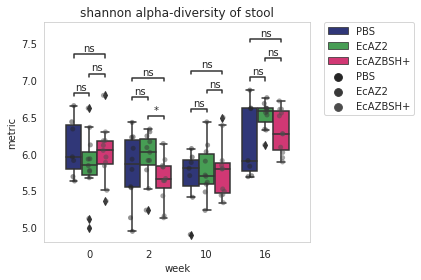

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

2_EcAZ2 vs. 2_EcAZBSH+: Mann-Whitney-Wilcoxon test two-sided, P_val:2.155e-02 U_stat=9.600e+01
10_PBS vs. 10_EcAZ2: Mann-Whitney-Wilcoxon test two-sided, P_val:4.344e-01 U_stat=4.350e+01
10_EcAZ2 vs. 10_EcAZBSH+: Mann-Whitney-Wilcoxon test two-sided, P_val:4.597e-01 U_stat=4.400e+01
16_PBS vs. 16_EcAZ2: Mann-Whitney-Wilcoxon test two-sided, P_val:8.529e-02 U_stat=1.900e+01
16_EcAZ2 vs. 16_EcAZBSH+: Mann-Whitney-Wilcoxon test two-sided, P_val:6.694e-01 U_stat=6.750e+01
0_PBS vs. 0_EcAZ2: Mann-Whitney-Wilcoxon test two-sided, P_val:7.172e-01 U_stat=4.300e+01
0_EcAZ2 vs. 0_EcAZBSH+: Mann-Whitney-Wilcoxon test two-sided, P_val:6.936e-01 U_stat=5.400e+01
2_PBS vs. 2_EcAZ2: Mann-Whitney-Wilcoxon test two-sided, P_val:5.495e-01 U_stat=6.400e+01
10_PBS vs. 10_EcAZBSH+: Mann-Whitney-Wilcoxon test two-sided, P_val:1.0

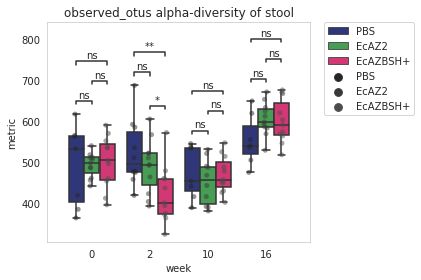

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

2_EcAZ2 vs. 2_EcAZBSH+: Mann-Whitney-Wilcoxon test two-sided, P_val:8.955e-01 U_stat=5.800e+01
10_PBS vs. 10_EcAZ2: Mann-Whitney-Wilcoxon test two-sided, P_val:9.611e-01 U_stat=3.600e+01
10_EcAZ2 vs. 10_EcAZBSH+: Mann-Whitney-Wilcoxon test two-sided, P_val:7.513e-01 U_stat=5.000e+01
16_PBS vs. 16_EcAZ2: Mann-Whitney-Wilcoxon test two-sided, P_val:1.473e-01 U_stat=2.200e+01
16_EcAZ2 vs. 16_EcAZBSH+: Mann-Whitney-Wilcoxon test two-sided, P_val:8.955e-01 U_stat=5.800e+01
0_PBS vs. 0_EcAZ2: Mann-Whitney-Wilcoxon test two-sided, P_val:8.529e-02 U_stat=1.900e+01
0_EcAZ2 vs. 0_EcAZBSH+: Mann-Whitney-Wilcoxon test two-sided, P_val:5.114e-01 U_stat=7.100e+01
2_PBS vs. 2_EcAZ2: Mann-Whitney-Wilcoxon test two-sided, P_val:5.495e-01 U_stat=6.400e+01
10_PBS vs. 10_EcAZBSH+: Mann-Whitney-Wilcoxon test two-sided, P_val:7.8

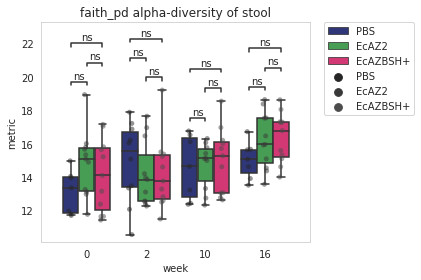

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

16_PBS vs. 16_EcAZ2: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=2.500e+01
16_EcAZ2 vs. 16_EcAZBSH+: Mann-Whitney-Wilcoxon test two-sided, P_val:3.854e-01 U_stat=3.600e+01
16_PBS vs. 16_EcAZBSH+: Mann-Whitney-Wilcoxon test two-sided, P_val:2.243e-01 U_stat=3.900e+01


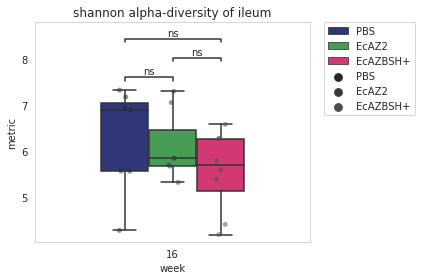

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

16_PBS vs. 16_EcAZ2: Mann-Whitney-Wilcoxon test two-sided, P_val:5.229e-01 U_stat=3.000e+01
16_EcAZ2 vs. 16_EcAZBSH+: Mann-Whitney-Wilcoxon test two-sided, P_val:1.321e-01 U_stat=4.150e+01
16_PBS vs. 16_EcAZBSH+: Mann-Whitney-Wilcoxon test two-sided, P_val:5.620e-02 U_stat=4.500e+01


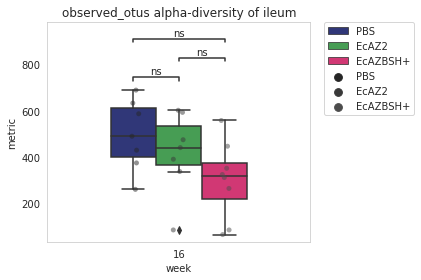

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

16_PBS vs. 16_EcAZ2: Mann-Whitney-Wilcoxon test two-sided, P_val:7.983e-01 U_stat=2.200e+01
16_EcAZ2 vs. 16_EcAZBSH+: Mann-Whitney-Wilcoxon test two-sided, P_val:1.832e-01 U_stat=4.000e+01
16_PBS vs. 16_EcAZBSH+: Mann-Whitney-Wilcoxon test two-sided, P_val:1.480e-01 U_stat=4.100e+01


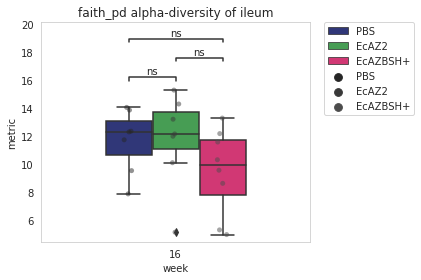

In [14]:
for organ, md, alphas in (('stool', md_stool, stool_alphas), ('ileum', md_ileum, ileum_alphas) ):
    for n, m in enumerate(all_metrics):
        t = md.copy()
        t['metric'] = alphas[m]
        treatment_order = ('PBS', 'EcAZ2', 'EcAZBSH+')
        week_order = sorted(t.week.unique())
        comparison_pairs = []
        for w in week_order:
            for p1, p2 in combinations(treatment_order, 2):
                comparison_pairs.append(((w, p1), (w, p2)))
        args = {
            'data': t,
            'y': 'metric',
            'x': 'week',
            'order': week_order,
            'hue': 'treatment',
            'hue_order': treatment_order,
        }
        ax = sns.boxplot(palette=treatment_colors, **args,)
        sns.stripplot(ax=ax, dodge=True, alpha=0.5, color='0.3', **args)
        ax.set_title(f'{m} alpha-diversity of {organ}')
        annotator = Annotator(ax, comparison_pairs, **args)
        annotator.configure(test='Mann-Whitney', text_format='star', loc='inside')
        annotator.apply_and_annotate()
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.) # legend to top-right
        plt.tight_layout()
        plt.savefig(f'alpha_diversity.{organ}.{m}.by_week.svg')
        plt.show()
    